## Selection of filters for the model

### Contents
* [Task description](#Task-description)
* [Model description](#Model-description)
* [The parameters studied](#The-parameters-studied)
* [Parameters value area](#Parameters-value-area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Dataset bypass](#Dataset-bypass)
* [Creating a research object](#Creating-a-research-object)
* [Results](#Results)
* [Conclusion](#Conclusion)

### Task description
Select the parameters for Unet architecture, to suppress noise on the seismograms.

### Model description
layout dictionary:
* __c__ - 1d-convolutional block.
* __a__ - activation function.
* __d__ - dropout layer.
* __t__ - 1d-transposed convolition.

This is a Unet-like architecture with following blocks:
* Encoder:
    
    Encoder could be decsribed by layout _ca ca_ where:
    * c - block:
        - kernel size = 7
    * activation - _elu_
* Decoder:
    
    Decoders' layout is _ca ca_ where:
    * c - block:
        - kernel size = 7
    * activation - _elu_
* Downsample:
    
    Downsamples' layout is _p d_ where:
    * p - block:
        - pool_size = 2
        - pool_stride = 2
    * d -block:
        - dropout_rate = 0.05
* Upsample:
    
    Upsamples' layout is _tad_ where:
    * t - block:
        - kernel_size = 7
        - strides = 2
    * d -block:
        - dropout_rate = 0.05
    * activation - _elu_
    
### The parameters studied
A number of filters

### Parameters value area
* _Initial number of filters_ - $8, 16$

* _Number of Unet blocks_ - $3, 5, 8.$
                       
### Metrics
Pixel-based difference module between prediction and target.

### Dataset loading
Dataset is given by 2 SEGY files with a seismogram before and after ground-roll attenuation according to LIFT procedure. The seismorgam contains 176K traces combined in 51 field records. 

First, we index field records:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import tensorflow as tf

sys.path.append('../..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline, B, V, F, C
from seismicpro.batchflow.models.tf import UNet
from seismicpro.batchflow.research import Research, Option
from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot, merge_segy_files,
                            show_research, print_results)


plt.style.use('ggplot')

path_raw = '/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))

### Dataset bypass:
* Define model config
* Define index and train / test.

In [2]:
model_config = {
    'initial_block/inputs': 'x',
    'inputs': dict(x={'shape': (3000, 1)}, 
                   y={'name':'targets', 'shape': (3000, 1)}),
    'body/filters': C('filters'),
    'body/encoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
    'body/decoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/upsample': dict(layout='tad', kernel_size=7, strides=2,
                          dropout_rate=0.05, activation=tf.nn.elu),
    'loss':'l1',
    'optimizer': 'Adam'
}

In [3]:
train_index = index.create_subset(index.indices[:5])
train_set = Dataset(TraceIndex(train_index), SeismicBatch)
test_set = Dataset(TraceIndex(index.create_subset(index.indices[20:21])), SeismicBatch)

Create an instance of train and test pipelines.

In [4]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(np.vstack(batch.raw), -1),
                          'y': np.expand_dims(np.vstack(batch.lift), -1)}}
B_SIZE = 128
train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', UNet, 'unet', model_config)
                  .train_model('unet', make_data=make_data,
                               fetches='loss', save_to=V('loss'), mode='w')
                  .run(B_SIZE, n_epochs=None, drop_last=True, shuffle=True, lazy=True)
                 ) << train_set

test_pipeline = (Pipeline()
                    .import_model('unet', C('import_from'))
                    .init_variable('res', init_on_each_run=list())
                    .init_variable('raw', init_on_each_run=list())
                    .init_variable('lift', init_on_each_run=list())
                    .load(components=('raw', 'lift'), tslice=np.arange(3000), fmt='segy')
                    .update_variable('raw', B('raw'), mode='a')
                    .update_variable('lift', B('lift'), mode='a')
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('res'), mode='a')
                    .run(B_SIZE, n_epochs=1, drop_last=True, shuffle=True, lazy=True)
                   ) << test_set

Define of auxiliary functions.

In [5]:
def get_l1(iteration, experiment, pipeline):
    """ Calculate l1 norm."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    res = np.squeeze(np.vstack(pipeline.get_variable("res")), axis=-1)
    lift = np.vstack(np.concatenate(pipeline.get_variable("lift")))
    return np.mean(np.abs(res - lift))

def save_model(iteration, experiment, pipeline, model_name, path='./'):
    """ Save model to a path."""
    path = os.path.join(path, experiment[pipeline].config.alias(as_string=True) + '_' + str(iteration))
    pipeline = experiment[pipeline].pipeline
    pipeline.save_model(model_name, path)

### Creating a research object
After pipeline creation let's define reserach instance.

In [6]:
opts = Option('filters', [[8, 16, 32],
                          [16, 32, 64],
                          [8, 16, 32, 64, 128],
                          [16, 32, 64, 128, 256],
                          [8, 8, 16, 16, 32, 32, 64, 64, 128, 128],
                          [16, 16, 32, 32, 64, 64, 128, 128, 256, 256]])
research = (Research()
            .pipeline(train_pipeline, variables='loss', name='train')
            .pipeline(test_pipeline, name='test_ppl', execute='%5',
                      run=True, import_from='train')
            .grid(opts)
            .function(get_l1, returns='l1', name='test',
                      execute='%5', pipeline='test_ppl')
            .function(save_model, execute=-1, pipeline='train',
                      model_name='unet', path='saved_models/')
)

Now it's time to train research instance.

In [6]:
NUM_REPEAT = 10
NUM_ITERS = 500
research_name = 'reserach_filter'

research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name=research_name, workers=5,
             gpu=[1, 2, 3, 6, 7], progress_bar=True)

Research reserach_filter is starting...


100%|██████████| 13500/13500 [39:46<00:00,  5.66it/s]


### Results

Loss functions vs a number of iterations for each parameters set:

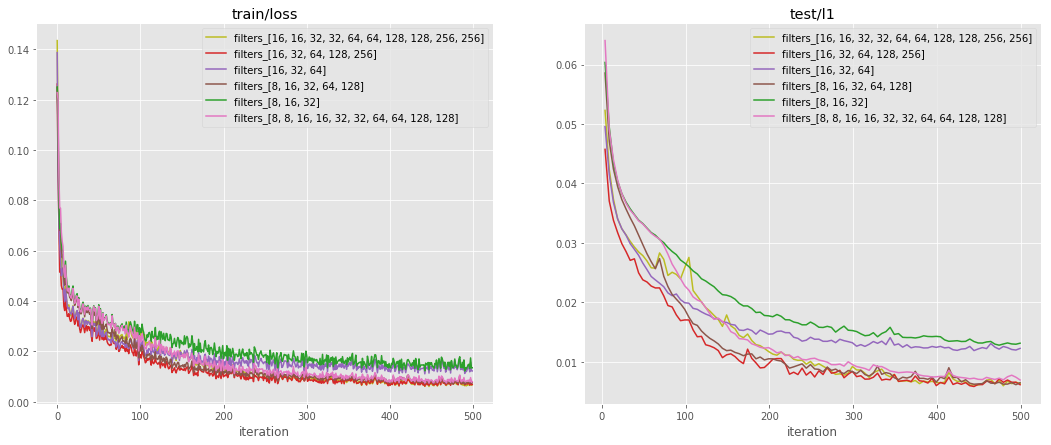

In [7]:
df = research.load_results(use_alias=True)
show_research(df, layout=['train/loss', 'test/l1'], average_repetitions=True, color=list(mcolors.TABLEAU_COLORS.keys()))

It is difficult to understand from the charts which model shows the best quality.

In [9]:
z = print_results(df, 'test/l1', True, sort_by='test_mean',ascending=True, n_last=100)
z

,test_mean,test_std
"filters_[16, 32, 64, 128, 256]",0.006453,0.000388
"filters_[16, 16, 32, 32, 64, 64, 128, 128, 256, 256]",0.006586,0.000502
"filters_[8, 16, 32, 64, 128]",0.006732,0.000675
"filters_[8, 8, 16, 16, 32, 32, 64, 64, 128, 128]",0.007345,0.000364
"filters_[16, 32, 64]",0.012275,0.000284
"filters_[8, 16, 32]",0.013314,0.000338


### Conclusions

We can see, that the best quality shows model with following parameters:
* _Initial number of filters_ - 16
* _Number of Unet blocks_ - 5.